# General Linear Model Analysis

## Load the data from the previous steps

In [2]:
from nilearn.glm.first_level import FirstLevelModel
import nibabel as nib
from nilearn import plotting

TR = 0.72
fmri_LR_img_path = "dataset/subject101410/fMRI/tfMRI_MOTOR_LR/tfMRI_MOTOR_LR.nii"
fmri_RL_img_path = "dataset/subject101410/fMRI/tfMRI_MOTOR_RL/tfMRI_MOTOR_RL.nii"

fmri_LR_img = nib.load(fmri_LR_img_path)
fmri_RL_img = nib.load(fmri_RL_img_path)

data_LR = fmri_LR_img.get_fdata()
data_RL = fmri_RL_img.get_fdata()

print(f"File LR loaded! Data shape: {data_LR.shape}")
print(f"File RL loaded! Data shape: {data_RL.shape}")

File LR loaded! Data shape: (91, 109, 91, 284)
File RL loaded! Data shape: (91, 109, 91, 284)


Assume we also have `n_vols` and `vol_shape`.

In [3]:
n_vols = n_vols_LR = n_vols_RL = data_LR.shape[3]
vol_shape = vol_shape_LR = vol_shape_RL = data_LR.shape[:3]

## 3. Design Matrix Investigation

First, we load the data relative to the events in both recordings.

In [4]:
import pandas as pd

events_RL_df = pd.read_csv("dataset/subject101410/fMRI/tfMRI_MOTOR_RL/events_RL.csv", sep=',')
events_RL_df = events_RL_df.rename(columns={'condition': 'trial_type'})

events_LR_df = pd.read_csv("dataset/subject101410/fMRI/tfMRI_MOTOR_LR/events_LR.csv", sep=',')
events_LR_df = events_LR_df.rename(columns={'condition': 'trial_type'})

print("EVENTS LR: \n", events_LR_df.head())
print("\n=================================\n")
print("EVENTS RL: \n", events_RL_df.head())
print("\n")

EVENTS LR: 
    onset  duration trial_type
0    0.0       8.0        NaN
1    8.0       3.0        cue
2   11.0      12.0         rh
3   23.0       3.0        cue
4   26.0      12.0         lf


EVENTS RL: 
    onset  duration trial_type
0    0.0       8.0        NaN
1    8.0       3.0        cue
2   11.0      12.0         lh
3   23.0       3.0        cue
4   26.0      12.0         rf




Now we try to build a Design matrix based off the dimension of our data and the events that are indicated in the related file. We use `drift_order=4`, but the parameter can be easily changed and/or tuned.

### IMPORTANT
This is the first version of a design matrix, more experimentation is needed with additional regressors.

/opt/conda/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:198: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


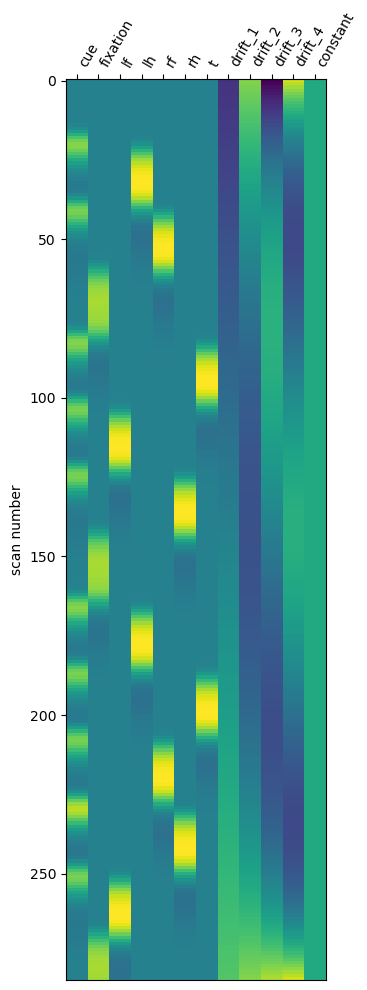

In [106]:
import numpy as np
import nibabel as nib
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

frame_times = np.arange(n_vols) * TR

# Create a Design Matrix
design_matrix = make_first_level_design_matrix(
    frame_times,
    events=events_RL_df,
    hrf_model='spm',
    drift_model='polynomial', 
    drift_order=4
)

# Inspect the   Design Matrix
n_features = design_matrix.shape[1]
plot_design_matrix(design_matrix);

## 4. Running the GLM

In [107]:
from nilearn.glm.first_level import FirstLevelModel

fmri_glm = FirstLevelModel(t_r=TR, noise_model='ar1')

print("Now the model will fit the data (Slow process) ...")
fmri_glm = fmri_glm.fit(fmri_RL_img, design_matrices=design_matrix)
print("Fit completed")

Now the model will fit the data (Slow process) ...


/opt/conda/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)


Fit completed


Create statistical maps for each (meaningful) regressor.

In [108]:
import numpy as np

labels = ['cue', 'fixation', 'lf', 'lh', 'rf', 'rh', 't']

conditions = {}
for i, label in enumerate(labels):
    vec = np.zeros(n_features)
    vec[i] = 1
    conditions[label] = vec

for key, value in conditions.items():
    print(f"{key:<10}: {value}")

cue       : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
fixation  : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
lf        : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
lh        : [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
rf        : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
rh        : [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
t         : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


Now let's save the statistical maps into specific files.

In [109]:
import os
import os.path as op

glm_output_dir = op.join(os.getcwd(), 'dataset/derivative/preprocessed_data/subject101410/GLM')
os.makedirs(glm_output_dir, exist_ok=True)

for regressor in labels:
    print(f"Computing {regressor} statistical map")
    stat_map = fmri_glm.compute_contrast(
        regressor,
        output_type = 'z_score'
    )
    filename = os.path.join(glm_output_dir, f"zmap_{regressor}.nii.gz")
    nib.save(stat_map, filename)
    print(f"  --> Map saved: {filename}")

Computing cue statistical map
  --> Map saved: /data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_cue.nii.gz
Computing fixation statistical map
  --> Map saved: /data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_fixation.nii.gz
Computing lf statistical map
  --> Map saved: /data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_lf.nii.gz
Computing lh statistical map
  --> Map saved: /data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_lh.nii.gz
Computing rf statistical map
  --> Map saved: /data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_rf.nii.gz
Computing rh statistical map
  --> Map saved: /data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_rh.nii.gz
Computing t statistical map
  --> Map saved: /data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_t.nii.gz


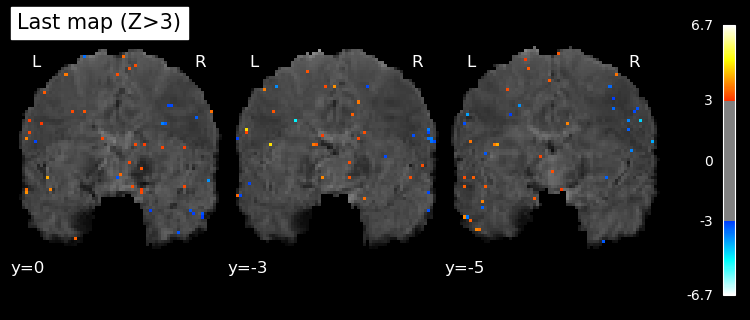

In [110]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(fmri_LR_img),
stat_map = nib.load('/data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_rh.nii.gz')
plot_stat_map(stat_map, bg_img=mean_img_[0], threshold=3,
              display_mode='y', cut_coords=[0,-3,-5], black_bg=True,
              title='Last map (Z>3)')
plt.show()

## 5. Hand Motion against Feet motion

In [113]:
hands_vs_feet = conditions['lh'] + conditions['rh'] - conditions['lf'] - conditions['rf']

print(f"Computing Hands vs. Feet contrast...")
stat_map = fmri_glm.compute_contrast(
    hands_vs_feet,
    output_type='z_score'
)
hands_vs_feet_filename = os.path.join(glm_output_dir, f"zmap_hands_vs_feet.nii.gz")
nib.save(stat_map, hands_vs_feet_filename)
print(f"  --> Hands vs. Feet contrast map saved: {hands_vs_feet_filename}")

Computing Hands vs. Feet contrast...
  --> Hands vs. Feet contrast map saved: /data/nssp-mp1/dataset/derivative/preprocessed_data/subject101410/GLM/zmap_hands_vs_feet.nii.gz


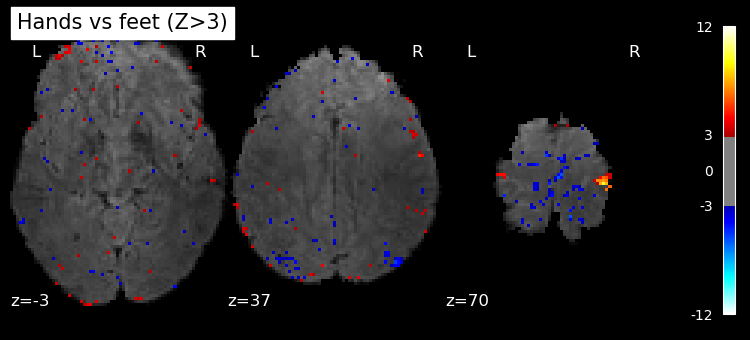

In [114]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(fmri_LR_img),
plot_stat_map(stat_map, bg_img=mean_img_[0], threshold=3.0,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title='Hands vs feet (Z>3)')
plt.show()

## 6. Results against the Atlas

In [115]:
from nilearn import datasets

print("Loading of the AAL atlas...")
atlas_aal = datasets.fetch_atlas_aal(verbose=0)
# atlas_aal.maps is the path to the nii.gz file
# atlas_aal.labels is a list of region names


print(f"Atlas has {len(atlas_aal.labels)} regions.")
print("Example of some regions:", atlas_aal.labels[13:16])

Loading of the AAL atlas...
Atlas has 116 regions.
Example of some regions: ['Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R']


In [117]:
import nibabel as nib
from nilearn.maskers import NiftiLabelsMasker
import numpy as np

# Load the contrast map
z_map = nib.load(hands_vs_feet_filename) 
print(z_map.shape)

# standardize=False
masker = NiftiLabelsMasker(
    labels_img=atlas_aal.maps, 
    standardize=False,
    memory='nilearn_cache',
    verbose=0
)

# We need to expand z_map to 4d
z_map_3d = z_map.get_fdata()
z_map_4d = nib.Nifti1Image(np.expand_dims(z_map_3d, axis=3), z_map.affine)

print("Extraction of average values for each region...")
region_values = masker.fit_transform(z_map_4d)

# region_values now is an array like: [[val1, val2, ... val116]]
region_values_1d = region_values.ravel()

print("Extraction finished.")

(91, 109, 91)
Extraction of average values for each region...
Extraction finished.


In [41]:
import pandas as pd

# Create DataFrame for a clean report
report_df = pd.DataFrame({
    'AAL_region': atlas_aal.labels,
    'avg_zscore': region_values_1d
})

# Remove empty regions
report_df = report_df[report_df['avg_zscore'] != 0]

# Sort to find the maximums
report_ordered = report_df.sort_values(by='avg_zscore', ascending=False)

# Print the top 10 regions with the most Contrast
print("\n Regions with Maximum Contrast")
print(report_ordered.head(10))


 Regions with Maximum Contrast
             AAL_region  avg_zscore
113            Vermis_8    0.289190
94        Cerebelum_3_L    0.214353
112            Vermis_7    0.202965
12    Frontal_Inf_Tri_L    0.194087
10   Frontal_Inf_Oper_L    0.162861
15    Frontal_Inf_Orb_R    0.161858
43          Calcarine_R    0.142625
93    Cerebelum_Crus2_R    0.135948
74           Pallidum_L    0.111644
35      Cingulum_Post_R    0.108192


Plot the contrast map against the Parcellation Atlas.

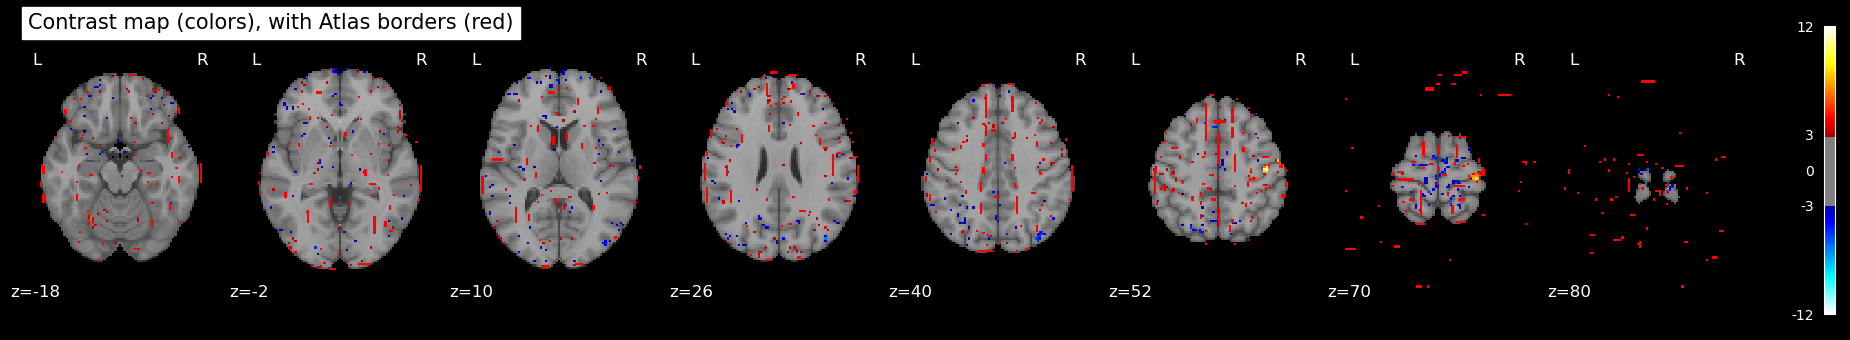

In [121]:
display = plotting.plot_stat_map(
    z_map, 
    threshold=3.0,
    display_mode='z',
    cut_coords=8,
    title="Contrast map (colors), with Atlas borders (red)",
    black_bg=True
)

display.add_edges(
    atlas_aal.maps,
    color='r'
)

plt.show()